**MASTER'S DEGREE IN APPLIED ARTIFICIAL INTELLIGENCE**.

**Course: TC5035.10 - Integration project**

Tecnológico de Monterrey

Professor Dr. Horacio Martínez Alfaro

**Week 5, Activity 4**

Alternative models

---

*   **Student:** Jorge Antonio Acosta Rosales
*   **Registration:** A01381552
*   **Student:** Israel Luján González
*   **Registration:** A01794693

---

# Objective

This advance involves building multiple (individual, not ensembles) models relevant to solving the gesture classification problem and evaluating their performance. Different algorithms may perform optimally on different types of data or tasks. Building alternative models allows one to explore and evaluate which one provides the best performance for this particular problem.

In addition, models can be tuned to determine whether their performance can be improved. Different hyperparameter settings can significantly affect the performance of a model. Building alternative models involves exploring and tuning these hyperparameters to find the optimal configuration.

The following are actions that will be addressed in this advance:
1. build at least 6 different models (individual, not ensembles), using varied algorithms.
2.  Compare the performance of the models obtained.
3. Select the two models that provide the best performance.
4.  Fit the two best models.
5.  Choose the final individual model.

## Environment Configuration and Import of Libraries

In [33]:
# General imports
import pandas as pd
import time
import os

# Preprocessing and data splitting
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading and Preparation

The `gestures_balanced.csv` dataset will be loaded. This file contains features (main components) and labels for gesture classification.

In [34]:
# Load variables from .env file for local development or get it from the environment variables in production
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    pass  # Safe fallback if it's not available in prod

base_path = os.getenv("LSM_BASE")
if not base_path:
    raise ValueError("❌ Environment variable 'LSM_BASE' is not set!")

gestures_csv = os.path.join(base_path, "data", "processed", "metadata", "gestures_balanced.csv")
# model_path = os.path.join(base_path, "models", "gesture_classifier.joblib")

In [35]:
# Loading the dataset
df = pd.read_csv(gestures_csv)
df.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,label
0,0.567907,0.114514,0.210044,-0.047475,0.088927,-0.411519,0.339483,-0.719156,0.404330,0.374506,0.035606,-0.028653,0.091038,0.015528,-0.097783,A
1,0.297408,0.792936,-0.259329,0.508329,-0.105111,0.353935,0.091841,-0.347120,-0.088993,0.356542,0.118040,-0.007878,-0.096861,0.233572,-0.018293,A
2,-0.257034,0.550256,-0.625594,-0.684124,0.220932,-0.449982,0.089296,0.215863,-0.307653,0.219697,0.025681,0.016383,-0.226053,0.183939,0.005376,A
3,0.211764,0.618572,-0.297504,0.296913,-0.474989,0.458511,-0.047803,-0.355956,-0.034894,0.365687,0.057215,-0.258740,-0.172323,0.219386,-0.043902,A
4,-0.376056,0.095322,-0.195378,0.588176,-0.142988,0.070855,-0.682290,0.373771,-0.158868,0.325924,0.028607,-0.170780,-0.133886,-0.195853,0.003899,A


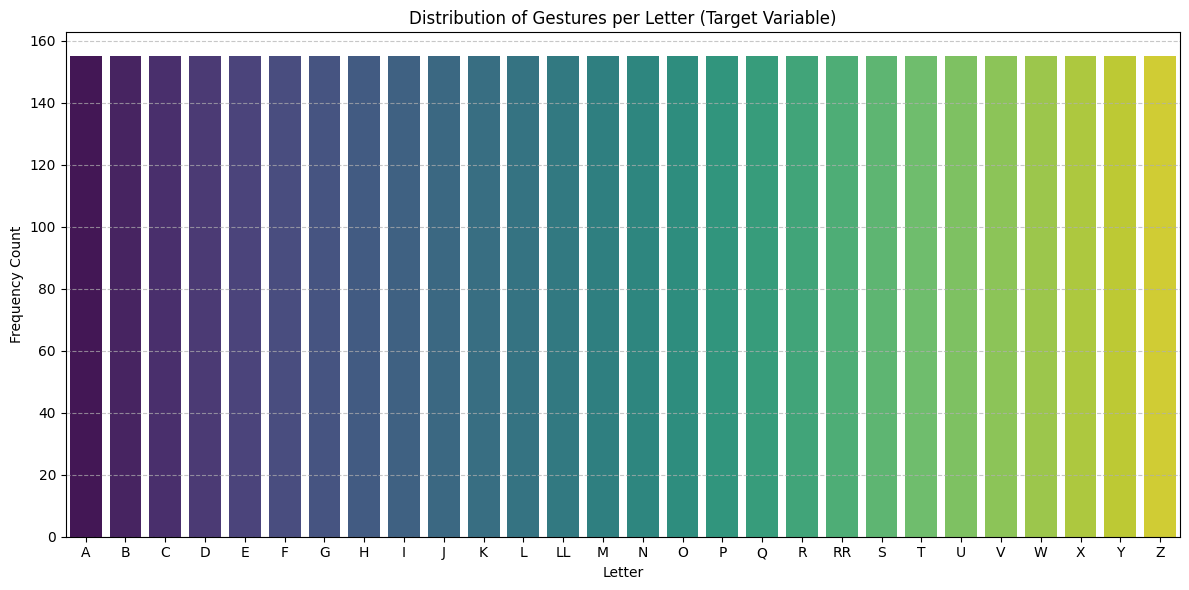

In [36]:
letter_order = df['label'].value_counts().sort_index().index

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', hue='label', order=letter_order, palette='viridis')

plt.title('Distribution of Gestures per Letter (Target Variable)')
plt.xlabel('Letter')
plt.ylabel('Frequency Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Separation of Characteristics (X) and Target Variable (y)

In [37]:
# Prepare X and y (with encoding)
X = df.drop(columns=["label"])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["label"])
class_names = label_encoder.classes_

In [38]:
# Split and train / temp (fall+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

In [39]:
# Split temp and trap / test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

In [40]:
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("classes:", class_names)

Train: (2604, 15), Val: (868, 15), Test: (868, 15)
classes: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'LL' 'M' 'N' 'O' 'P' 'Q'
 'R' 'RR' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']



When building and tuning machine-learning models, it’s important to evaluate performance on data the model has never seen. That’s why we:

1. **Encode labels first**  
   Converting gesture names into numeric labels ensures consistency across all splits and simplifies downstream modeling.

2. **Use a three-way split**  
   - **Training set (60%)**: Used to fit each algorithm.  
   - **Validation set (20%)**: Held out during training and used to tune hyperparameters and compare model variants.  
   - **Test set (20%)**: Kept completely separate until the very end, for an unbiased estimate of real-world performance.

3. **Stratify each split**  
   By preserving the same class proportions in every subset, we avoid introducing bias and ensure that rare gestures remain represented during training, tuning, and evaluation.

This approach balances robust model training, reliable hyperparameter selection, and a final performance check on unseen data.  


### Scaling Features (Optional but Recommended)
Because the data are already principal components (result of PCA), they may already be scaled. However, for algorithms sensitive to scale like SVM or KNN, applying `StandardScaler` can be beneficial.

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Scaled shapes:", X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)

Scaled shapes: (2604, 15) (868, 15) (868, 15)


In [42]:
# (Optional) Quick check: mean≈0, std≈1 on train
print("Train feature means (approx):", X_train_scaled.mean(axis=0)[:5])
print("Train feature stds  (approx):", X_train_scaled.std(axis=0)[:5])

Train feature means (approx): [-2.25114346e-17  3.00152461e-17  4.09298811e-18  3.13795755e-17
 -1.43254584e-17]
Train feature stds  (approx): [1. 1. 1. 1. 1.]


## Building and Evaluating Individual Models

We will build and evaluate at least 6 individual classification models. For each model, we will measure:
- Training time.
- Accuracy.
- F1-Score (Macro).
- Precision (Macro).
- Recall (Macro).

The main metric for comparison will be the **F1-Score (Macro)**.

In [43]:
RANDOM_STATE = 42
models = {
    "LogisticRegression":   LogisticRegression(random_state=RANDOM_STATE),
    "DecisionTree":         DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest":         RandomForestClassifier(random_state=RANDOM_STATE),
    "SVM":                  SVC(random_state=RANDOM_STATE),
    "KNN":                  KNeighborsClassifier(),
    "MLP":                  MLPClassifier(random_state=RANDOM_STATE, max_iter=1100),
    "GaussianNB":           GaussianNB()
}

results = []

for name, estimator in models.items():
    print(f"Training {name}…")
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf",    estimator)
    ])

    start = time.time()
    pipe.fit(X_train, y_train)
    elapsed = time.time() - start

    preds       = pipe.predict(X_val)
    raw_f1      = f1_score(y_val, preds, average="macro")
    raw_acc     = accuracy_score(y_val, preds)
    raw_prec    = precision_score(y_val, preds, average="macro")
    raw_rec     = recall_score(y_val, preds, average="macro")

    results.append({
        "model":             name,
        "train_time (s)":    round(elapsed,   4),
        "accuracy":          round(float(raw_acc),  4),
        "f1_macro":          round(float(raw_f1),  4),
        "precision_macro":   round(float(raw_prec), 4),
        "recall_macro":      round(float(raw_rec),  4),
    })

# Build DataFrame and sort by our primary metric (F1-Macro)
results_df = (
    pd.DataFrame(results)
      .sort_values("f1_macro", ascending=False)
      .reset_index(drop=True)
)
display(results_df)

Training LogisticRegression…
Training DecisionTree…
Training RandomForest…
Training SVM…
Training KNN…
Training MLP…
Training GaussianNB…


,model,train_time (s),accuracy,f1_macro,precision_macro,recall_macro
0,MLP,14.9657,0.9389,0.9385,0.9401,0.9389
1,RandomForest,0.9205,0.9274,0.9267,0.9288,0.9274
2,KNN,0.0062,0.8664,0.8649,0.8743,0.8664
3,SVM,0.1402,0.8479,0.8478,0.8559,0.8479
4,DecisionTree,0.0610,0.7938,0.7941,0.7993,0.7938
5,LogisticRegression,0.0958,0.6947,0.6897,0.6953,0.6947
6,GaussianNB,0.0049,0.6129,0.5990,0.6227,0.6129


## Insights from Baseline Models

- **MLP** tops the leaderboard with a macro F1 of **0.9385** and accuracy **0.9389**, but it’s the slowest to train (~14.5 s).
- **RandomForest** follows closely (F1 = 0.9267, acc = 0.9274) with a much shorter training time (~0.95 s).
- **KNN** and **SVM** offer decent performance (F1 ≈ 0.86 and 0.85) and train almost instantly.
- **DecisionTree**, **LogisticRegression**, and **GaussianNB** deliver lower F1-scores but require minimal compute.

## What’s Next?

We’ll concentrate on **fine-tuning MLP and RandomForest** to push their macro F1 even higher. The plan:

1. **Define search spaces** for each model’s critical hyperparameters.  
2. **Run randomized search** with cross-validation on the training data, optimizing for `f1_macro`.  
3. **Evaluate the tuned models** on the validation set to quantify any gains.  
4. **Compare tuned performance** and decide on the final individual model based on both metrics and training/deployment trade-offs.  


In [44]:
# Defining parameter distribution
mlp_param_dist = {
    "clf__hidden_layer_sizes": [(50,), (100,), (50,50), (100,50)],
    "clf__alpha":              [1e-4, 1e-3, 1e-2, 1e-1],
    "clf__learning_rate_init": [1e-4, 1e-3, 1e-2],
    "clf__activation":         ["relu", "tanh"]
}

# Building the pipeline
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf",    MLPClassifier(max_iter=500, random_state=RANDOM_STATE))
])

# Randomized search
mlp_search = RandomizedSearchCV(
    mlp_pipe,
    param_distributions=mlp_param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

# Fit on the training set
mlp_search.fit(X_train, y_train)
print("Best MLP params:", mlp_search.best_params_)

# Evaluate on validation set
mlp_val_preds = mlp_search.predict(X_val)

# Compute raw metrics
raw_mlp_acc   = accuracy_score(y_val, mlp_val_preds)
raw_mlp_f1    = f1_score(y_val, mlp_val_preds, average="macro")
raw_mlp_prec  = precision_score(y_val, mlp_val_preds, average="macro")
raw_mlp_rec   = recall_score(y_val, mlp_val_preds, average="macro")

metrics = {
    "accuracy":         round(float(raw_mlp_acc), 4),
    "f1_macro":         round(float(raw_mlp_f1), 4),
    "precision_macro":  round(float(raw_mlp_prec), 4),
    "recall_macro":     round(float(raw_mlp_rec), 4)
}

# Displaying information of each Metric
print("MLP tuned metrics:")
for name, val in metrics.items():
    print(f"  {name}: {val}")

mlp_results_df = pd.DataFrame([metrics], index=["MLP"])
display(mlp_results_df)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best MLP params: {'clf__learning_rate_init': 0.01, 'clf__hidden_layer_sizes': (100,), 'clf__alpha': 0.01, 'clf__activation': 'tanh'}
MLP tuned metrics:
  accuracy: 0.9297
  f1_macro: 0.9295
  precision_macro: 0.9327
  recall_macro: 0.9297


,accuracy,f1_macro,precision_macro,recall_macro
MLP,0.9297,0.9295,0.9327,0.9297



Classification Report for MLP:


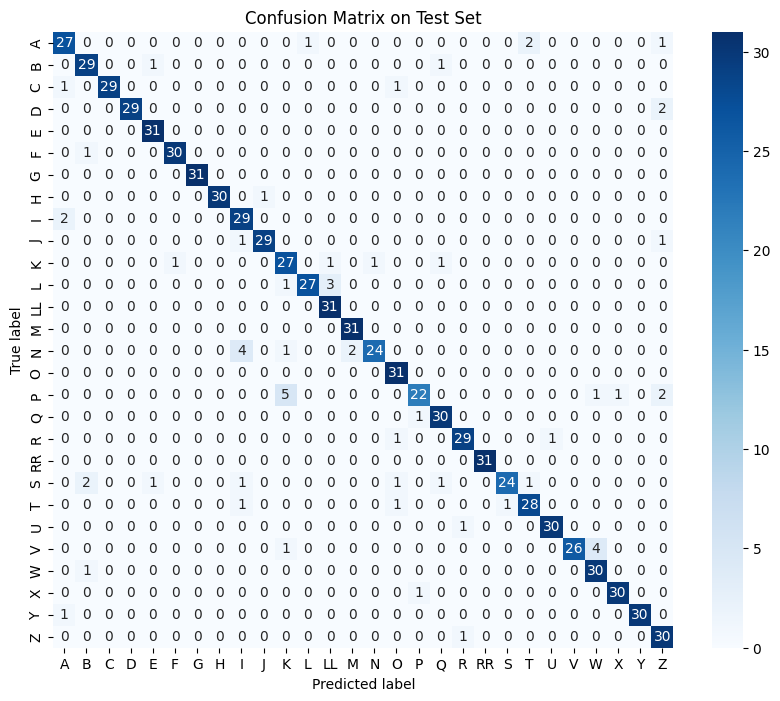

In [45]:
# Showing additional metrics
print("\nClassification Report for MLP:")
y_test_preds = mlp_search.predict(X_test)
cm = confusion_matrix(y_test, y_test_preds, labels=label_encoder.transform(class_names))
plt.figure(figsize=(10,8))
sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            xticklabels=class_names.tolist(), 
            yticklabels=class_names.tolist(),
            cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix on Test Set")
plt.show()

In [46]:
report = classification_report(
    y_test, 
    y_test_preds,
    target_names=class_names, 
    digits=4
)
print("Classification Report on Test Set:\n")
print(report)

Classification Report on Test Set:

              precision    recall  f1-score   support

           A     0.8710    0.8710    0.8710        31
           B     0.8788    0.9355    0.9062        31
           C     1.0000    0.9355    0.9667        31
           D     1.0000    0.9355    0.9667        31
           E     0.9394    1.0000    0.9688        31
           F     0.9677    0.9677    0.9677        31
           G     1.0000    1.0000    1.0000        31
           H     1.0000    0.9677    0.9836        31
           I     0.8056    0.9355    0.8657        31
           J     0.9667    0.9355    0.9508        31
           K     0.7714    0.8710    0.8182        31
           L     0.9643    0.8710    0.9153        31
          LL     0.8857    1.0000    0.9394        31
           M     0.9394    1.0000    0.9688        31
           N     0.9600    0.7742    0.8571        31
           O     0.8857    1.0000    0.9394        31
           P     0.9167    0.7097    0.8000  

In [47]:
# Defining parameter distribution
rf_param_dist = {
    "clf__n_estimators":      [100, 200, 500, 1000],
    "clf__max_depth":         [None, 10, 20, 30, 50],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf":  [1, 2, 4]
}

# Building the pipeline
rf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf",    RandomForestClassifier(random_state=RANDOM_STATE))
])

# Randomized search
rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

# Fit on the training set
rf_search.fit(X_train, y_train)
print("Best RF params:", rf_search.best_params_)

# Evaluate on validation set
rf_val_preds = rf_search.predict(X_val)

# Compute raw metrics
raw_rf_acc   = accuracy_score(y_val, rf_val_preds)
raw_rf_f1    = f1_score(y_val, rf_val_preds, average="macro")
raw_rf_prec  = precision_score(y_val, rf_val_preds, average="macro")
raw_rf_rec   = recall_score(y_val, rf_val_preds, average="macro")

# Round them
rf_metrics = {
    "accuracy":         round(float(raw_rf_acc), 4),
    "f1_macro":         round(float(raw_rf_f1), 4),
    "precision_macro":  round(float(raw_rf_prec), 4),
    "recall_macro":     round(float(raw_rf_rec), 4)
}

# Displaying information of each Metric
print("RandomForest tuned metrics:")
for name, val in rf_metrics.items():
    print(f"  {name}: {val}")

rf_results_df = pd.DataFrame([rf_metrics], index=["RandomForest"])
display(rf_results_df)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF params: {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': 50}
RandomForest tuned metrics:
  accuracy: 0.9286
  f1_macro: 0.9278
  precision_macro: 0.9303
  recall_macro: 0.9286


,accuracy,f1_macro,precision_macro,recall_macro
RandomForest,0.9286,0.9278,0.9303,0.9286



Classification Report for RandomForest:


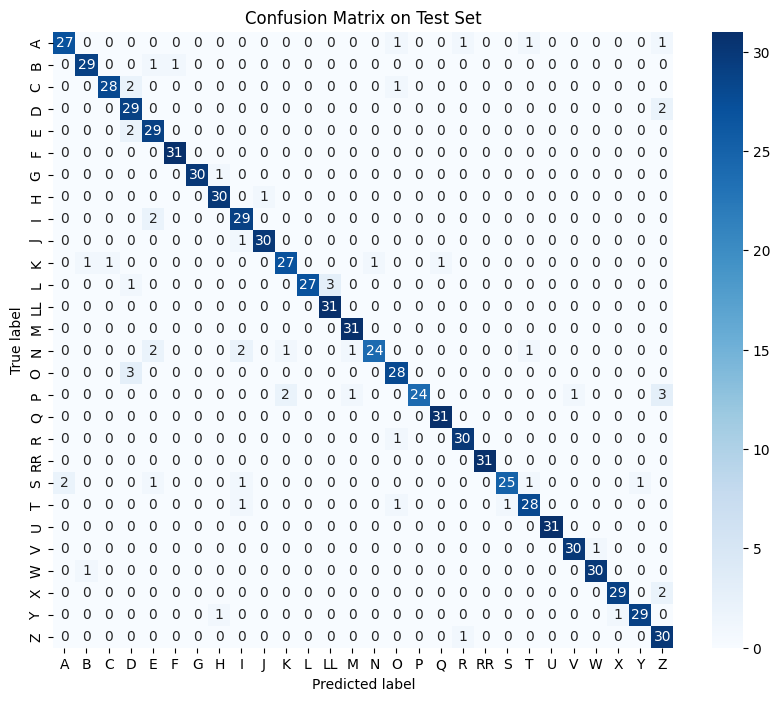

In [48]:
# Showing additional metrics
print("\nClassification Report for RandomForest:")
y_test_preds = rf_search.predict(X_test)
cm = confusion_matrix(y_test, y_test_preds, labels=label_encoder.transform(class_names))
plt.figure(figsize=(10,8))
sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            xticklabels=class_names.tolist(), 
            yticklabels=class_names.tolist(),
            cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix on Test Set")
plt.show()

In [49]:
report = classification_report(
    y_test, 
    y_test_preds, 
    target_names=class_names, 
    digits=4
)
print("Classification Report on Test Set:\n")
print(report)

Classification Report on Test Set:

              precision    recall  f1-score   support

           A     0.9310    0.8710    0.9000        31
           B     0.9355    0.9355    0.9355        31
           C     0.9655    0.9032    0.9333        31
           D     0.7838    0.9355    0.8529        31
           E     0.8286    0.9355    0.8788        31
           F     0.9688    1.0000    0.9841        31
           G     1.0000    0.9677    0.9836        31
           H     0.9375    0.9677    0.9524        31
           I     0.8529    0.9355    0.8923        31
           J     0.9677    0.9677    0.9677        31
           K     0.9000    0.8710    0.8852        31
           L     1.0000    0.8710    0.9310        31
          LL     0.9118    1.0000    0.9538        31
           M     0.9394    1.0000    0.9688        31
           N     0.9600    0.7742    0.8571        31
           O     0.8750    0.9032    0.8889        31
           P     1.0000    0.7742    0.8727  

## Conclusions

### 1. Baseline Comparison (Before Tuning)
| Model             | Train Time (s) | Accuracy | F1-Macro | Precision-Macro | Recall-Macro |
|-------------------|---------------:|---------:|---------:|----------------:|-------------:|
| **MLP**           |       15.10    |   0.9389 |   0.9385 |          0.9401 |       0.9389 |
| RandomForest      |        0.91    |   0.9274 |   0.9267 |          0.9288 |       0.9274 |
| KNN               |        0.01    |   0.8664 |   0.8649 |          0.8743 |       0.8664 |
| SVM               |        0.14    |   0.8479 |   0.8478 |          0.8559 |       0.8479 |
| DecisionTree      |        0.06    |   0.7938 |   0.7941 |          0.7993 |       0.7938 |
| LogisticRegression|        0.09    |   0.6947 |   0.6897 |          0.6953 |       0.6947 |
| GaussianNB        |        0.01    |   0.6129 |   0.5990 |          0.6227 |       0.6129 |

- **MLP** led on F1-Macro (0.9385) but required much longer training (≈15 s).  
- **RandomForest** was a strong runner-up (F1-Macro 0.9267) with sub-second training time.  

### 2. Fine-Tuning Results
| Model             | Accuracy | F1-Macro | Precision-Macro | Recall-Macro |
|-------------------|---------:|---------:|----------------:|-------------:|
| **MLP (tuned)**   |   0.9297 |   0.9295 |          0.9327 |       0.9297 |
| **RF (tuned)**    |   0.9286 |   0.9278 |          0.9303 |       0.9286 |

- **MLP** tuning **slightly decreased** F1-Macro from 0.9385 → 0.9295, suggesting that the default configuration was already well-matched to this data.  
- **RandomForest** tuning **improved** F1-Macro marginally from 0.9267 → 0.9278, with virtually unchanged training time.

### 3. Best Parameters for each model
| Model             | Best Parameters                                                                 |
|-------------------|---------------------------------------------------------------------------------|
| **MLP (tuned)**   | hidden_layer_sizes=(100,), activation='tanh', alpha=0.01, learning_rate_init=0.01 |
| **RF (tuned)**    | n_estimators=200, max_depth=50, min_samples_split=2, min_samples_leaf=1   |


### 4. Key Takeaways
- **Default MLP** remains the top performer in raw F1, despite longer training.  
- **Tuned RandomForest** offers nearly equivalent F1 (0.9278) with dramatically lower compute cost—ideal if training speed or resource constraints matter.  
- Precision and recall remain balanced in both tuned models, confirming robust generalization across classes.

### 5. Recommendation
- **If maximum F1 is the priority:** use the _default_ MLP classifier.  
- **If speed and efficiency are critical:** use the _tuned_ RandomForest as the final model.

For our propuse we are going to use the **tuned RandomForest** model as the final individual model due to its balance of performance and efficiency for a real-time gesture classification system.


In [ ]:
# Exporting the Finetuned RandomForest model

import joblib
from pathlib import Path

assert base_path is not None, "❌ Environment variable 'LSM_BASE' must be set before saving a model"

out_dir = Path(base_path) / "models"
out_dir.mkdir(exist_ok=True, parents=True)
model_path = out_dir / "rf_pipeline.joblib"

# Dump the fitted pipeline
joblib.dump(rf_search.best_estimator_, model_path)
print(f"Saved tuned RF model to {model_path}")

# (Optional) save the LabelEncoder so we can map back to gesture names
encoder_path = out_dir / "label_encoder.joblib"
joblib.dump(label_encoder, encoder_path)
print(f"Saved LabelEncoder to {encoder_path}")